# CANデータGPU処理ベンチマーク

CANバイナリデータのGPU処理とCPU処理の比較、およびParquet出力の検証を行います。

## 1. 環境設定とインポート

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from pathlib import Path
import sys

# Add parent directory to path for imports
sys.path.append('..')

# Import decoders
#from gpu_can_decoder import GPUCANDecoder
from gpu_can_decoder_optimized import OptimizedGPUCANDecoder
from cpu_can_decoder import CPUCANDecoder

print("ライブラリのインポート完了")

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
import sys

# Add parent directory to path for imports
sys.path.append('..')

# Import decoders
#from gpu_can_decoder import GPUCANDecoder
from gpu_can_decoder_optimized import OptimizedGPUCANDecoder
from cpu_can_decoder import CPUCANDecoder

print("ライブラリのインポート完了")

ライブラリのインポート完了


In [ ]:
# テスト用データの生成 - 1,000,000メッセージ以上のみ
test_sizes = [
    1_000_000,     # 1M
    5_000_000,     # 5M
    10_000_000,    # 10M
    50_000_000,    # 50M
    100_000_000,   # 100M
    # 500_000_000,   # 500M (メモリに注意)
]
print("テストデータサイズ:", test_sizes)

In [3]:
def load_or_generate_test_data(n_messages):
    """キャッシュされたテストデータを読み込むか、存在しない場合は生成する"""
    import os  # 念のため関数内でもインポート
    
    # サイズ名を決定
    size_name = f"{n_messages // 1_000_000}M"
    cache_file = f"test_data_cache/test_data_{size_name}.npz"
    
    # キャッシュファイルが存在する場合は読み込む
    if os.path.exists(cache_file):
        print(f"  キャッシュから読み込み: {cache_file}")
        data = np.load(cache_file)
        return data['timestamps'], data['addresses'], data['data_bytes']
    
    # 存在しない場合は生成（既存の関数を使用）
    print(f"  データを生成中...")
    return generate_synthetic_can_data(n_messages)

def generate_synthetic_can_data(n_messages):
    """合成CANデータの生成（OpenPilot DBCファイルに準拠）"""
    # リアルなCANデータ分布を模倣
    address_distribution = {
        170: 0.037,  # 4輪速度
        37: 0.037,   # ステアリング
        36: 0.037,
        740: 0.044,
        608: 0.022,
        180: 0.018,
    }
    
    # アドレスを生成
    addresses = []
    for addr, prob in address_distribution.items():
        count = int(n_messages * prob)
        addresses.extend([addr] * count)
    
    # 残りはランダムなアドレス
    remaining = n_messages - len(addresses)
    other_addresses = np.random.choice([452, 466, 467, 705, 321, 562], remaining)
    addresses.extend(other_addresses)
    
    # シャッフル
    np.random.shuffle(addresses)
    addresses = np.array(addresses[:n_messages], dtype=np.int64)
    
    # タイムスタンプ（実データと同じ範囲）
    timestamps = np.linspace(46408.0, 46468.0, n_messages)
    
    # データバイト
    data_bytes = np.zeros((n_messages, 8), dtype=np.uint8)
    
    for i in range(n_messages):
        if addresses[i] == 170:  # 4輪速度
            # OpenPilot DBC: (0.01,-67.67) "kph" for Toyota RAV4
            for j in range(4):
                speed_kmh = np.random.uniform(55, 65)  # 55-65 km/h
                raw_value = int((speed_kmh + 67.67) / 0.01)
                data_bytes[i, j*2] = (raw_value >> 8) & 0xFF
                data_bytes[i, j*2 + 1] = raw_value & 0xFF
        elif addresses[i] == 37:  # ステアリング
            # 固定値パターン（実データと同じ）
            data_bytes[i] = [0x00, 0x00, 0x10, 0x00, 0xC0, 0x00, 0x00, 0xFD]
        else:
            # その他はランダム
            data_bytes[i] = np.random.randint(0, 256, 8, dtype=np.uint8)
    
    return timestamps, addresses, data_bytes

In [ ]:
# ベンチマーク結果格納
benchmark_results = []

for n_messages in test_sizes:
    print(f"\n--- {n_messages:,} メッセージの処理 ---")
    
    # データ読み込み（キャッシュを優先）
    timestamps, addresses, data_bytes = load_or_generate_test_data(n_messages)
    data_size_mb = (timestamps.nbytes + addresses.nbytes + data_bytes.nbytes) / (1024**2)
    
    # 抽出対象データサイズの計算（アドレス170と37のみ）
    target_mask = (addresses == 170) | (addresses == 37)
    target_count = np.sum(target_mask)
    target_size_mb = (timestamps[target_mask].nbytes + addresses[target_mask].nbytes + data_bytes[target_mask].nbytes) / (1024**2)
    
    print(f"全データサイズ: {data_size_mb:.1f} MB（内抽出対象データサイズ: {target_size_mb:.1f} MB）")
    
    # GPU処理（最適化）
    opt_gpu_start = time.time()
    opt_gpu_chunk_results = optimized_gpu_decoder.decode_batch_for_benchmark(timestamps, addresses, data_bytes)
    opt_gpu_time = time.time() - opt_gpu_start
    
    # CPU処理（全てのサイズで実測）
    cpu_start = time.time()
    cpu_results = cpu_decoder.decode_batch(timestamps, addresses, data_bytes, debug_timing=True)
    cpu_time = time.time() - cpu_start
    
    # CPU処理の詳細時間を表示（マスク作成を除外）
    if '_timing' in cpu_results:
        timing = cpu_results['_timing']
        # データ抽出（インデックス検索と配列割り当て）
        data_extract_time = timing.get('index_search', 0) + timing.get('array_allocation', 0)
        # 物理値変換（デコードループ、DataFrame作成、ソート）
        physical_convert_time = (timing.get('decode_loop', 0) + 
                               timing.get('wheel_df_creation', 0) + 
                               timing.get('wheel_sort', 0))
        
        print(f"\n  === CPU処理の詳細 ===")
        print(f"  データ抽出: {data_extract_time:.4f}秒")
        print(f"  物理値変換: {physical_convert_time:.4f}秒")
        print(f"  総処理時間: {data_extract_time + physical_convert_time:.4f}秒")
    
    # 結果記録
    result = {
        'n_messages': n_messages,
        'data_size_mb': data_size_mb,
        'opt_gpu_time': opt_gpu_time,
        'cpu_time': cpu_time,
        'speedup': cpu_time / opt_gpu_time,
        'opt_gpu_throughput': n_messages / opt_gpu_time / 1e6,
        'cpu_throughput': n_messages / cpu_time / 1e6
    }
    benchmark_results.append(result)
    
    print(f"\nGPU処理時間: {opt_gpu_time:.4f}秒 ({result['opt_gpu_throughput']:.1f} Mmsg/s)")
    print(f"CPU処理時間: {cpu_time:.4f}秒 ({result['cpu_throughput']:.1f} Mmsg/s)")
    print(f"高速化率: {result['speedup']:.1f}x")

# DataFrameに変換
benchmark_df = pd.DataFrame(benchmark_results)
benchmark_df

In [5]:
# ベンチマーク結果格納
benchmark_results = []

for n_messages in test_sizes:
    print(f"\n--- {n_messages:,} メッセージの処理 ---")
    
    # データ生成
    timestamps, addresses, data_bytes = generate_synthetic_can_data(n_messages)
    data_size_mb = (timestamps.nbytes + addresses.nbytes + data_bytes.nbytes) / (1024**2)
    
    # 抽出対象データサイズの計算（アドレス170と37のみ）
    target_mask = (addresses == 170) | (addresses == 37)
    target_count = np.sum(target_mask)
    target_size_mb = (timestamps[target_mask].nbytes + addresses[target_mask].nbytes + data_bytes[target_mask].nbytes) / (1024**2)
    
    print(f"全データサイズ: {data_size_mb:.1f} MB（内抽出対象データサイズ: {target_size_mb:.1f} MB）")
    
    # GPU処理（最適化）
    opt_gpu_start = time.time()
    opt_gpu_chunk_results = optimized_gpu_decoder.decode_batch_for_benchmark(timestamps, addresses, data_bytes)
    opt_gpu_time = time.time() - opt_gpu_start
    
    # CPU処理（全てのサイズで実測）
    cpu_start = time.time()
    cpu_results = cpu_decoder.decode_batch(timestamps, addresses, data_bytes, debug_timing=True)
    cpu_time = time.time() - cpu_start
    
    # CPU処理の詳細時間を表示（3つの主要ステップに集約）
    if '_timing' in cpu_results:
        timing = cpu_results['_timing']
        # マスク作成
        mask_time = timing.get('mask_creation', 0)
        # データ抽出（インデックス検索と配列割り当て）
        data_extract_time = timing.get('index_search', 0) + timing.get('array_allocation', 0)
        # 物理値変換（デコードループ、DataFrame作成、ソート）
        physical_convert_time = (timing.get('decode_loop', 0) + 
                               timing.get('wheel_df_creation', 0) + 
                               timing.get('wheel_sort', 0))
        
        print(f"\n  === CPU処理の詳細 ===")
        print(f"  マスク作成: {mask_time:.4f}秒")
        print(f"  データ抽出: {data_extract_time:.4f}秒")
        print(f"  物理値変換: {physical_convert_time:.4f}秒")
        print(f"  総処理時間: {cpu_time:.4f}秒")
    
    # 結果記録
    result = {
        'n_messages': n_messages,
        'data_size_mb': data_size_mb,
        'opt_gpu_time': opt_gpu_time,
        'cpu_time': cpu_time,
        'speedup': cpu_time / opt_gpu_time,
        'opt_gpu_throughput': n_messages / opt_gpu_time / 1e6,
        'cpu_throughput': n_messages / cpu_time / 1e6
    }
    benchmark_results.append(result)
    
    print(f"\nGPU処理時間: {opt_gpu_time:.4f}秒 ({result['opt_gpu_throughput']:.1f} Mmsg/s)")
    print(f"CPU処理時間: {cpu_time:.4f}秒 ({result['cpu_throughput']:.1f} Mmsg/s)")
    print(f"高速化率: {result['speedup']:.1f}x")

# DataFrameに変換
benchmark_df = pd.DataFrame(benchmark_results)
benchmark_df


--- 1,000,000 メッセージの処理 ---
全データサイズ: 22.9 MB（内抽出対象データサイズ: 1.7 MB）
  === GPU処理の詳細 ===
  データ抽出: 0.0048秒
  物理値変換: 0.0129秒
  総処理時間: 0.0177秒

  === CPU処理の詳細 ===
  マスク作成: 0.0005秒
  データ抽出: 0.0010秒
  物理値変換: 0.0697秒
  総処理時間: 0.0909秒

GPU処理時間: 0.0201秒 (49.8 Mmsg/s)
CPU処理時間: 0.0909秒 (11.0 Mmsg/s)
高速化率: 4.5x

--- 5,000,000 メッセージの処理 ---
全データサイズ: 114.4 MB（内抽出対象データサイズ: 8.5 MB）
  === GPU処理の詳細 ===
  データ抽出: 0.0293秒
  物理値変換: 0.0140秒
  総処理時間: 0.0433秒

  === CPU処理の詳細 ===
  マスク作成: 0.0025秒
  データ抽出: 0.0047秒
  物理値変換: 0.3445秒
  総処理時間: 0.4456秒

GPU処理時間: 0.0543秒 (92.2 Mmsg/s)
CPU処理時間: 0.4456秒 (11.2 Mmsg/s)
高速化率: 8.2x

--- 10,000,000 メッセージの処理 ---
全データサイズ: 228.9 MB（内抽出対象データサイズ: 16.9 MB）
  === GPU処理の詳細 ===
  データ抽出: 0.0459秒
  物理値変換: 0.0177秒
  総処理時間: 0.0636秒

  === CPU処理の詳細 ===
  マスク作成: 0.0049秒
  データ抽出: 0.0096秒
  物理値変換: 0.7155秒
  総処理時間: 0.9239秒

GPU処理時間: 0.0866秒 (115.5 Mmsg/s)
CPU処理時間: 0.9239秒 (10.8 Mmsg/s)
高速化率: 10.7x

--- 50,000,000 メッセージの処理 ---
全データサイズ: 1144.4 MB（内抽出対象データサイズ: 84.7 MB）
  === GPU処理の詳細 ===
  データ抽出: 0.

,n_messages,data_size_mb,opt_gpu_time,cpu_time,speedup,opt_gpu_throughput,cpu_throughput
0,1000000,22.888184,0.020083,0.090937,4.528035,49.792889,10.996579
1,5000000,114.440918,0.054256,0.445593,8.212791,92.155770,11.221005
2,10000000,228.881836,0.086552,0.923887,10.674346,115.537289,10.823829
3,50000000,1144.409180,0.340017,4.658934,13.702069,147.051539,10.732068


## 4. 速度比較の可視化

## 3. 速度比較の可視化

In [6]:
## 8. まとめ

## 5. 実データでのGPU/CPU処理とParquet出力

In [7]:
# 実データパス
input_path = "Example_1/b0c9d2329ad1606b|2018-08-02--08-34-47/40/processed_log/CAN/raw_can"

# GPU処理（最適化）
print("=== GPU処理（最適化） ===")
opt_gpu_start = time.time()
optimized_gpu_decoder.process_and_save(input_path, "gpu_optimized_output")
opt_gpu_total_time = time.time() - opt_gpu_start
print(f"\nGPU総処理時間（最適化）: {opt_gpu_total_time:.3f}秒\n")

# CPU処理
print("\n=== CPU処理 ===")
cpu_start = time.time()
cpu_decoder.process_and_save(input_path, "cpu_output")
cpu_total_time = time.time() - cpu_start
print(f"\nCPU総処理時間: {cpu_total_time:.3f}秒")

print(f"\n実データでの高速化率（最適化GPU）: {cpu_total_time/opt_gpu_total_time:.1f}x")

=== GPU処理（最適化） ===
最適化GPU CANデコーダー実行開始 (chunk_size=1)...
入力データ: 135,484 メッセージ
  処理中: 0 - 135,484
  === GPU処理の詳細 ===
  データ抽出: 0.0009秒
  物理値変換: 0.0129秒
  総処理時間: 0.0139秒
Saved: gpu_optimized_output/wheel_speeds.parquet (4974 rows)
Saved: gpu_optimized_output/vehicle_speed.parquet (4974 rows)
Saved: gpu_optimized_output/steering.parquet (4974 rows)

処理時間: 0.130 秒
スループット: 1.04 Mmessages/sec

GPU総処理時間（最適化）: 0.131秒


=== CPU処理 ===
CPU CANデコーダー実行開始...
入力データ: 135,484 メッセージ
  処理中: 0 - 100,000
  処理中: 100,000 - 135,484
Saved: cpu_output/wheel_speeds_cpu.parquet (4974 rows)
Saved: cpu_output/vehicle_speed_cpu.parquet (4974 rows)
Saved: cpu_output/steering_cpu.parquet (4974 rows)

処理時間: 0.024 秒
スループット: 5.75 Mmessages/sec

CPU総処理時間: 0.024秒

実データでの高速化率（最適化GPU）: 0.2x


/home/ubuntu/miniconda3/envs/cudf_dev/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 39 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


## 6. 出力結果の可視化と検証

In [8]:
# GPU出力の読み込み
gpu_vehicle_speed = pd.read_parquet("gpu_optimized_output/vehicle_speed.parquet")
gpu_wheel_speeds = pd.read_parquet("gpu_optimized_output/wheel_speeds.parquet")
gpu_steering = pd.read_parquet("gpu_optimized_output/steering.parquet")

# CPU出力の読み込み
cpu_vehicle_speed = pd.read_parquet("cpu_output/vehicle_speed_cpu.parquet")
cpu_wheel_speeds = pd.read_parquet("cpu_output/wheel_speeds_cpu.parquet")
cpu_steering = pd.read_parquet("cpu_output/steering_cpu.parquet")

print("=== 出力データサイズ ===")
print(f"GPU出力: {len(gpu_vehicle_speed)} 行")
print(f"CPU出力: {len(cpu_vehicle_speed)} 行")

=== 出力データサイズ ===
GPU出力: 4974 行
CPU出力: 4974 行


### 6.1 GPU/CPUデータの一致確認

In [9]:
# GPU/CPUデータの先頭20件を比較
print("=== GPU/CPUデータの一致確認 ===")
print(f"\nGPU車両速度データ: {len(gpu_vehicle_speed)} 行")
print(f"CPU車両速度データ: {len(cpu_vehicle_speed)} 行")

# データ数が同じか確認
if len(gpu_vehicle_speed) != len(cpu_vehicle_speed):
    print(f"\n⚠️ 警告: データ数が一致しません！ GPU: {len(gpu_vehicle_speed)}, CPU: {len(cpu_vehicle_speed)}")

# 先頭20件を表示
print("\n--- GPU車両速度データ（先頭20件）---")
print(gpu_vehicle_speed.head(20))

print("\n--- CPU車両速度データ（先頭20件）---") 
print(cpu_vehicle_speed.head(20))

# タイムスタンプの範囲を確認
print(f"\n--- タイムスタンプの範囲 ---")
print(f"GPU: {gpu_vehicle_speed['timestamp'].min():.6f} ~ {gpu_vehicle_speed['timestamp'].max():.6f}")
print(f"CPU: {cpu_vehicle_speed['timestamp'].min():.6f} ~ {cpu_vehicle_speed['timestamp'].max():.6f}")

# ソート順を確認
gpu_sorted = gpu_vehicle_speed['timestamp'].is_monotonic_increasing
cpu_sorted = cpu_vehicle_speed['timestamp'].is_monotonic_increasing
print(f"\n--- ソート状態 ---")
print(f"GPU timestamp昇順ソート: {gpu_sorted}")
print(f"CPU timestamp昇順ソート: {cpu_sorted}")

# タイムスタンプが完全一致するか確認
print("\n--- タイムスタンプの一致確認 ---")
if len(gpu_vehicle_speed) == len(cpu_vehicle_speed):
    timestamp_match = (gpu_vehicle_speed['timestamp'].values == cpu_vehicle_speed['timestamp'].values).all()
    print(f"タイムスタンプ完全一致: {timestamp_match}")
    
    if not timestamp_match:
        # 最初に不一致が見つかった箇所を表示
        for i in range(min(len(gpu_vehicle_speed), 100)):  # 最初の100件をチェック
            if gpu_vehicle_speed['timestamp'].iloc[i] != cpu_vehicle_speed['timestamp'].iloc[i]:
                print(f"\n最初の不一致箇所（index {i}）:")
                print(f"  GPU: {gpu_vehicle_speed['timestamp'].iloc[i]}")
                print(f"  CPU: {cpu_vehicle_speed['timestamp'].iloc[i]}")
                break

# 4輪速度データも確認
print("\n\n=== 4輪速度データの確認 ===")
print(f"GPU 4輪速度データ: {len(gpu_wheel_speeds)} 行")
print(f"CPU 4輪速度データ: {len(cpu_wheel_speeds)} 行")

# 4輪速度の先頭5件のみ表示
print("\n--- GPU 4輪速度データ（先頭5件）---")
print(gpu_wheel_speeds.head(5))

print("\n--- CPU 4輪速度データ（先頭5件）---")
print(cpu_wheel_speeds.head(5))

=== GPU/CPUデータの一致確認 ===

GPU車両速度データ: 4974 行
CPU車両速度データ: 4974 行

--- GPU車両速度データ（先頭20件）---
       timestamp     speed
0   46408.589503  7.974306
1   46408.598408  7.981250
2   46408.615894  7.985416
3   46408.629446  8.013194
4   46408.639317  8.047222
5   46408.650634  8.064583
6   46408.668155  8.083334
7   46408.673706  8.110416
8   46408.688939  8.127778
9   46408.697622  8.145834
10  46408.712503  8.161111
11  46408.720785  8.192361
12  46408.734313  8.223611
13  46408.745464  8.238890
14  46408.768697  8.259027
15  46408.771585  8.297222
16  46408.785092  8.308333
17  46408.790647  8.320833
18  46408.807868  8.332640
19  46408.818718  8.331249

--- CPU車両速度データ（先頭20件）---
       timestamp     speed
0   46408.589503  7.974306
1   46408.598408  7.981250
2   46408.615894  7.985416
3   46408.629446  8.013194
4   46408.639317  8.047222
5   46408.650634  8.064583
6   46408.668155  8.083334
7   46408.673706  8.110416
8   46408.688939  8.127778
9   46408.697622  8.145834
10  46408.712503  8.1

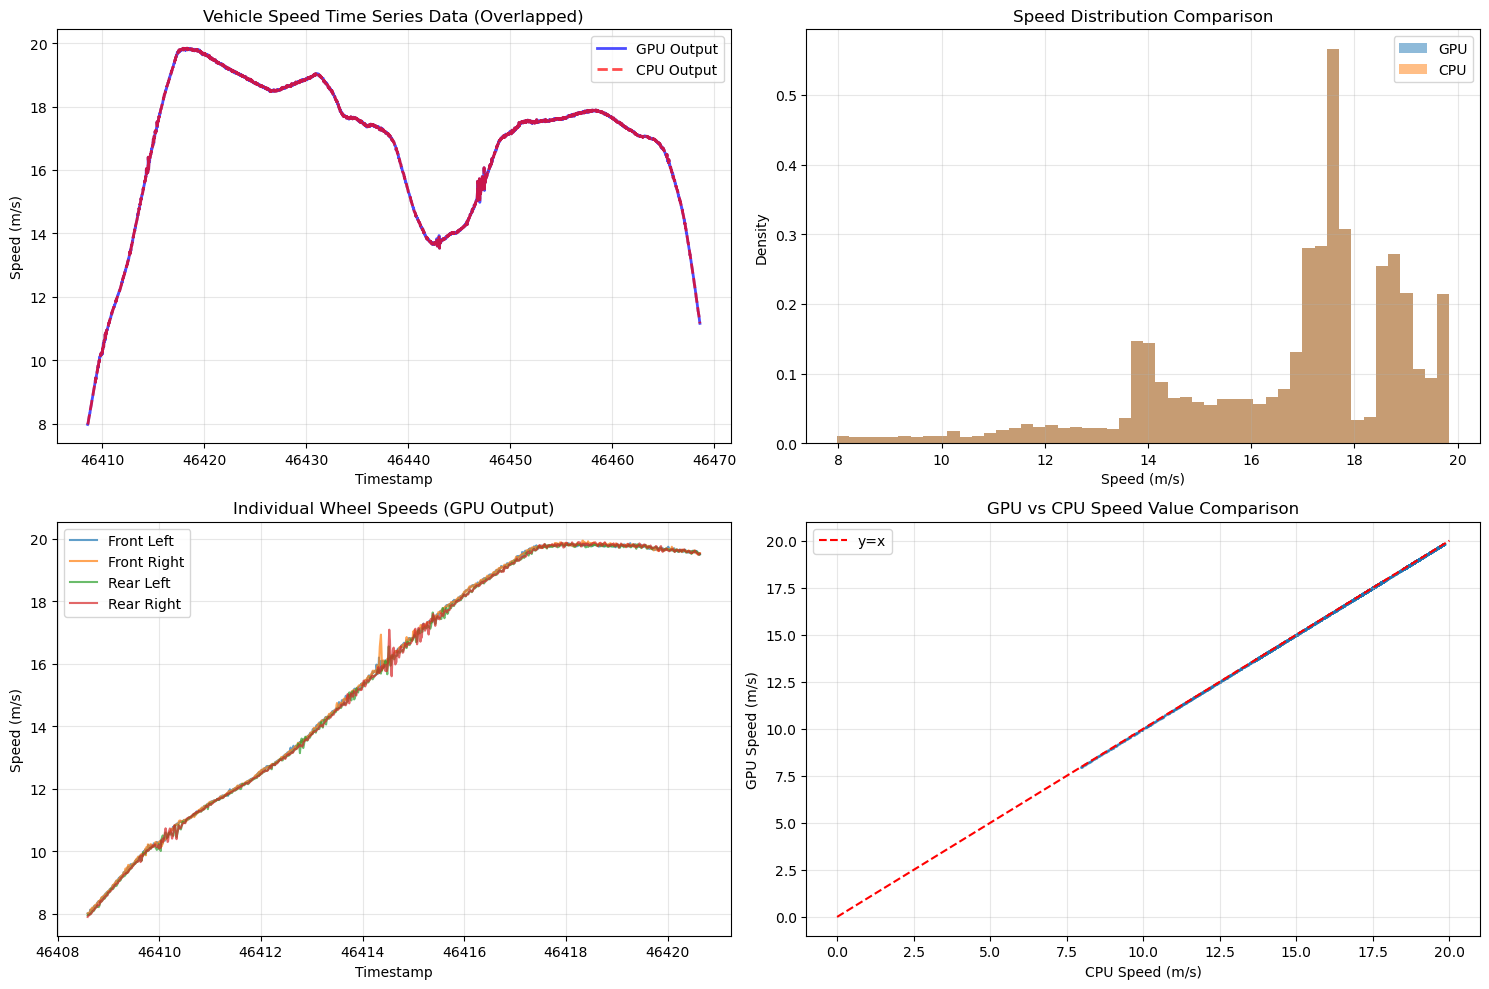

In [10]:
# Visualization of speed data - Combined view
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Vehicle speed time series - Both on same plot with transparency
axes[0, 0].plot(gpu_vehicle_speed['timestamp'], gpu_vehicle_speed['speed'], 
                label='GPU Output', alpha=0.7, linewidth=2, color='blue')
axes[0, 0].plot(cpu_vehicle_speed['timestamp'], cpu_vehicle_speed['speed'], 
                label='CPU Output', alpha=0.7, linewidth=2, color='red', linestyle='--')
axes[0, 0].set_xlabel('Timestamp')
axes[0, 0].set_ylabel('Speed (m/s)')
axes[0, 0].set_title('Vehicle Speed Time Series Data (Overlapped)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Speed distribution histogram
axes[0, 1].hist(gpu_vehicle_speed['speed'], bins=50, alpha=0.5, label='GPU', density=True)
axes[0, 1].hist(cpu_vehicle_speed['speed'], bins=50, alpha=0.5, label='CPU', density=True)
axes[0, 1].set_xlabel('Speed (m/s)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Speed Distribution Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 4-wheel speed comparison (first 1000 points)
n_points = 1000
axes[1, 0].plot(gpu_wheel_speeds['timestamp'][:n_points], 
                gpu_wheel_speeds['front_left'][:n_points], 
                label='Front Left', alpha=0.7)
axes[1, 0].plot(gpu_wheel_speeds['timestamp'][:n_points], 
                gpu_wheel_speeds['front_right'][:n_points], 
                label='Front Right', alpha=0.7)
axes[1, 0].plot(gpu_wheel_speeds['timestamp'][:n_points], 
                gpu_wheel_speeds['rear_left'][:n_points], 
                label='Rear Left', alpha=0.7)
axes[1, 0].plot(gpu_wheel_speeds['timestamp'][:n_points], 
                gpu_wheel_speeds['rear_right'][:n_points], 
                label='Rear Right', alpha=0.7)
axes[1, 0].set_xlabel('Timestamp')
axes[1, 0].set_ylabel('Speed (m/s)')
axes[1, 0].set_title('Individual Wheel Speeds (GPU Output)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# GPU vs CPU speed value scatter plot
# Merge on timestamp
merged = pd.merge(gpu_vehicle_speed, cpu_vehicle_speed, 
                  on='timestamp', suffixes=('_gpu', '_cpu'))
axes[1, 1].scatter(merged['speed_cpu'], merged['speed_gpu'], alpha=0.5, s=1)
axes[1, 1].plot([0, 20], [0, 20], 'r--', label='y=x')
axes[1, 1].set_xlabel('CPU Speed (m/s)')
axes[1, 1].set_ylabel('GPU Speed (m/s)')
axes[1, 1].set_title('GPU vs CPU Speed Value Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# 統計情報の比較
print("=== 速度データの統計情報 ===")
print("\nGPU出力:")
print(gpu_vehicle_speed['speed'].describe())
print("\nCPU出力:")
print(cpu_vehicle_speed['speed'].describe())

# 差分分析
if len(merged) > 0:
    diff = merged['speed_gpu'] - merged['speed_cpu']
    print("\n=== CPU vs GPU 差分分析 ===")
    print(f"平均差分: {diff.mean():.9f} m/s")
    print(f"最大差分: {diff.abs().max():.9f} m/s")
    print(f"標準偏差: {diff.std():.9f} m/s")

=== 速度データの統計情報 ===

GPU出力:
count    4974.000000
mean       16.732777
std         2.372856
min         7.974306
25%        15.432987
50%        17.462500
75%        18.531076
max        19.840973
Name: speed, dtype: float64

CPU出力:
count    4974.000000
mean       16.732777
std         2.372856
min         7.974306
25%        15.432987
50%        17.462500
75%        18.531076
max        19.840973
Name: speed, dtype: float64

=== CPU vs GPU 差分分析 ===
平均差分: 0.000000000 m/s
最大差分: 0.000000000 m/s
標準偏差: 0.000000000 m/s


## 7. GPU/CPU結果の詳細比較

GPU処理がCPU処理と同じ結果を生成していることを確認します。

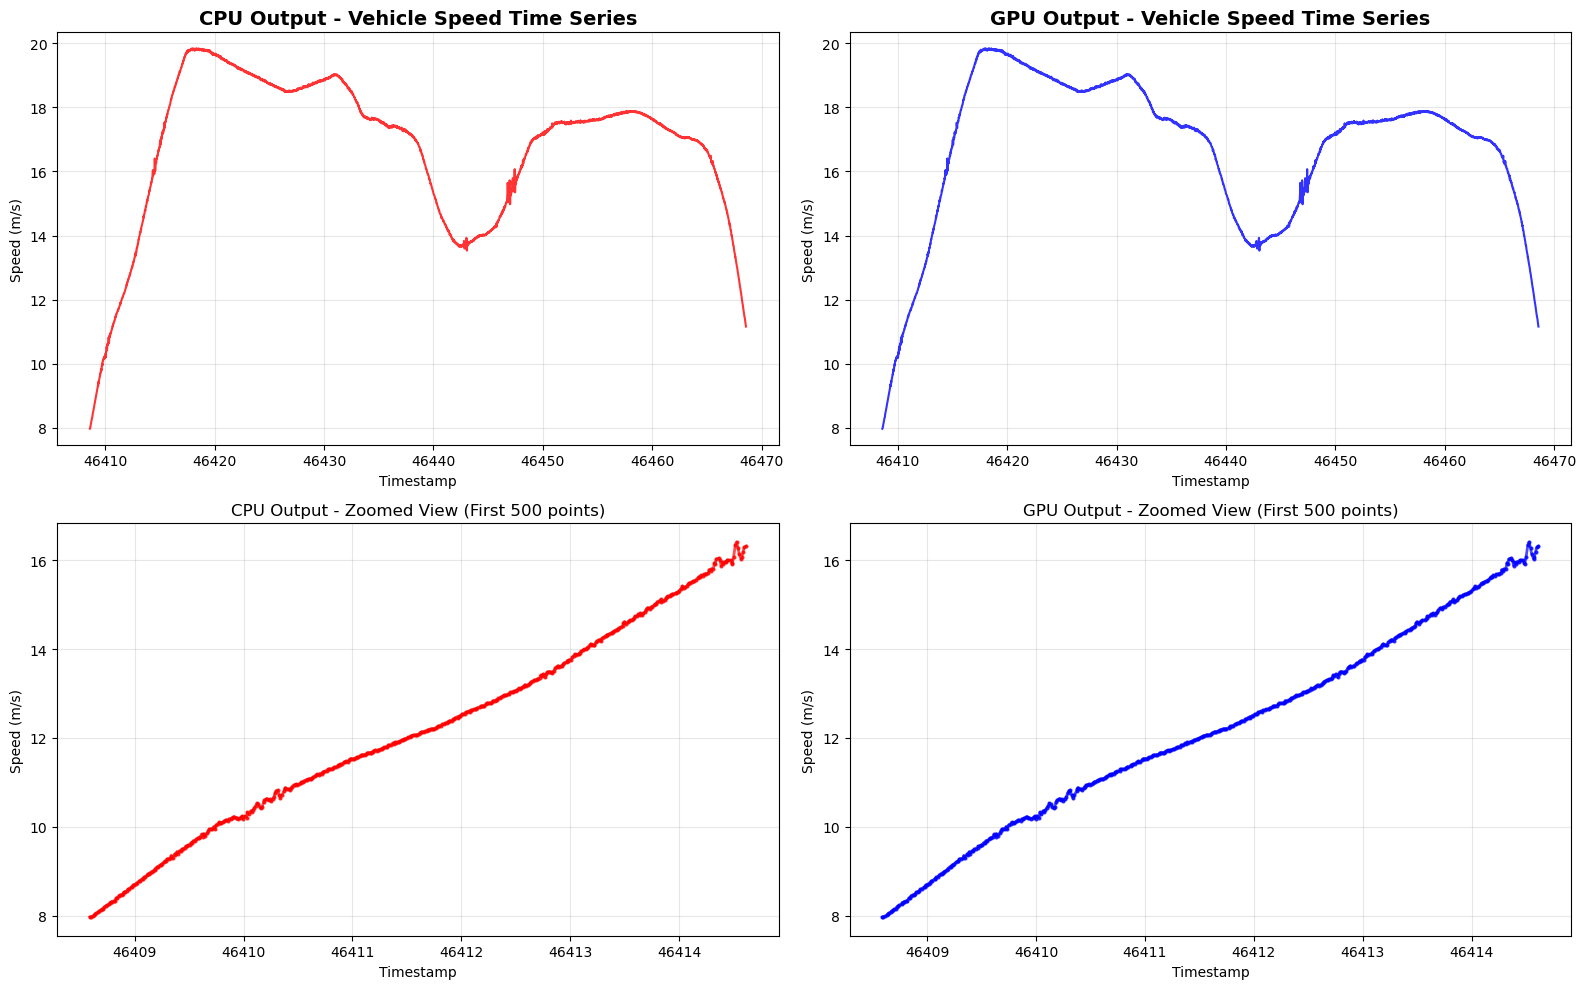


=== CPU vs GPU 差分分析 ===
サンプル数: 4,974
平均差分: 0.000000000 m/s
最大差分: 0.000000000 m/s
標準偏差: 0.000000000 m/s
差分の範囲: [0.000000000, 0.000000000] m/s

差分の分布:
  完全一致 (差分 = 0): 4,974 (100.0%)
  差分 < 1e-6: 4,974 (100.0%)
  差分 < 1e-3: 4,974 (100.0%)


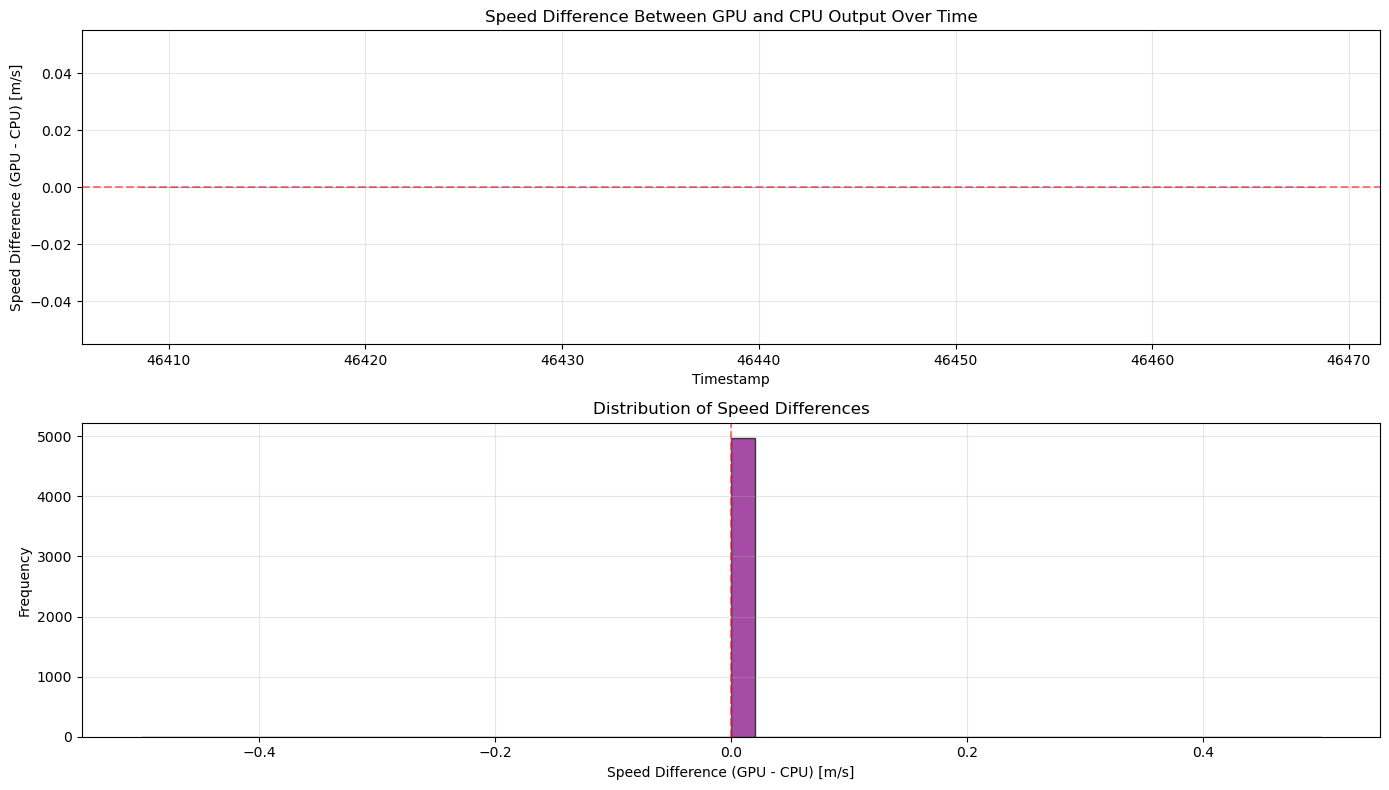

In [12]:
# 個別グラフ表示（CPU/GPU別）
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# CPU Output Only
ax1.plot(cpu_vehicle_speed['timestamp'], cpu_vehicle_speed['speed'], 
         color='red', linewidth=1.5, alpha=0.8)
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Speed (m/s)')
ax1.set_title('CPU Output - Vehicle Speed Time Series', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([cpu_vehicle_speed['speed'].min() - 0.5, cpu_vehicle_speed['speed'].max() + 0.5])

# GPU Output Only
ax2.plot(gpu_vehicle_speed['timestamp'], gpu_vehicle_speed['speed'], 
         color='blue', linewidth=1.5, alpha=0.8)
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Speed (m/s)')
ax2.set_title('GPU Output - Vehicle Speed Time Series', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([gpu_vehicle_speed['speed'].min() - 0.5, gpu_vehicle_speed['speed'].max() + 0.5])

# Zoomed view (first 500 points) - CPU
n_zoom = 500
ax3.plot(cpu_vehicle_speed['timestamp'][:n_zoom], cpu_vehicle_speed['speed'][:n_zoom], 
         color='red', linewidth=2, marker='o', markersize=2, alpha=0.7)
ax3.set_xlabel('Timestamp')
ax3.set_ylabel('Speed (m/s)')
ax3.set_title(f'CPU Output - Zoomed View (First {n_zoom} points)', fontsize=12)
ax3.grid(True, alpha=0.3)

# Zoomed view (first 500 points) - GPU
ax4.plot(gpu_vehicle_speed['timestamp'][:n_zoom], gpu_vehicle_speed['speed'][:n_zoom], 
         color='blue', linewidth=2, marker='o', markersize=2, alpha=0.7)
ax4.set_xlabel('Timestamp')
ax4.set_ylabel('Speed (m/s)')
ax4.set_title(f'GPU Output - Zoomed View (First {n_zoom} points)', fontsize=12)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 差分分析
print("\n=== CPU vs GPU 差分分析 ===")
if len(merged) > 0:
    diff = merged['speed_gpu'] - merged['speed_cpu']
    print(f"サンプル数: {len(merged):,}")
    print(f"平均差分: {diff.mean():.9f} m/s")
    print(f"最大差分: {diff.abs().max():.9f} m/s")
    print(f"標準偏差: {diff.std():.9f} m/s")
    print(f"差分の範囲: [{diff.min():.9f}, {diff.max():.9f}] m/s")
    
    # 差分の分布
    print(f"\n差分の分布:")
    print(f"  完全一致 (差分 = 0): {(diff == 0).sum():,} ({(diff == 0).sum() / len(diff) * 100:.1f}%)")
    print(f"  差分 < 1e-6: {(diff.abs() < 1e-6).sum():,} ({(diff.abs() < 1e-6).sum() / len(diff) * 100:.1f}%)")
    print(f"  差分 < 1e-3: {(diff.abs() < 1e-3).sum():,} ({(diff.abs() < 1e-3).sum() / len(diff) * 100:.1f}%)")
    
    # 差分プロット
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
    
    # 時系列差分
    ax1.plot(merged['timestamp'], diff, alpha=0.7, linewidth=0.5)
    ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Speed Difference (GPU - CPU) [m/s]')
    ax1.set_title('Speed Difference Between GPU and CPU Output Over Time')
    ax1.grid(True, alpha=0.3)
    
    # 差分のヒストグラム
    ax2.hist(diff, bins=50, alpha=0.7, color='purple', edgecolor='black')
    ax2.set_xlabel('Speed Difference (GPU - CPU) [m/s]')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Speed Differences')
    ax2.grid(True, alpha=0.3)
    ax2.axvline(x=0, color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
else:
    print("警告: マージされたデータがありません。タイムスタンプが一致しない可能性があります。")


=== 4輪速度データの比較 ===


/tmp/ipykernel_2882176/701333358.py:36: UserWarning: Glyph 23436 (\N{CJK UNIFIED IDEOGRAPH-5B8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2882176/701333358.py:36: UserWarning: Glyph 20840 (\N{CJK UNIFIED IDEOGRAPH-5168}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2882176/701333358.py:36: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2882176/701333358.py:36: UserWarning: Glyph 33268 (\N{CJK UNIFIED IDEOGRAPH-81F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ubuntu/miniconda3/envs/cudf_dev/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23436 (\N{CJK UNIFIED IDEOGRAPH-5B8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/miniconda3/envs/cudf_dev/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20840 (\N{CJK UNIFIED IDEOGRAPH-5168}

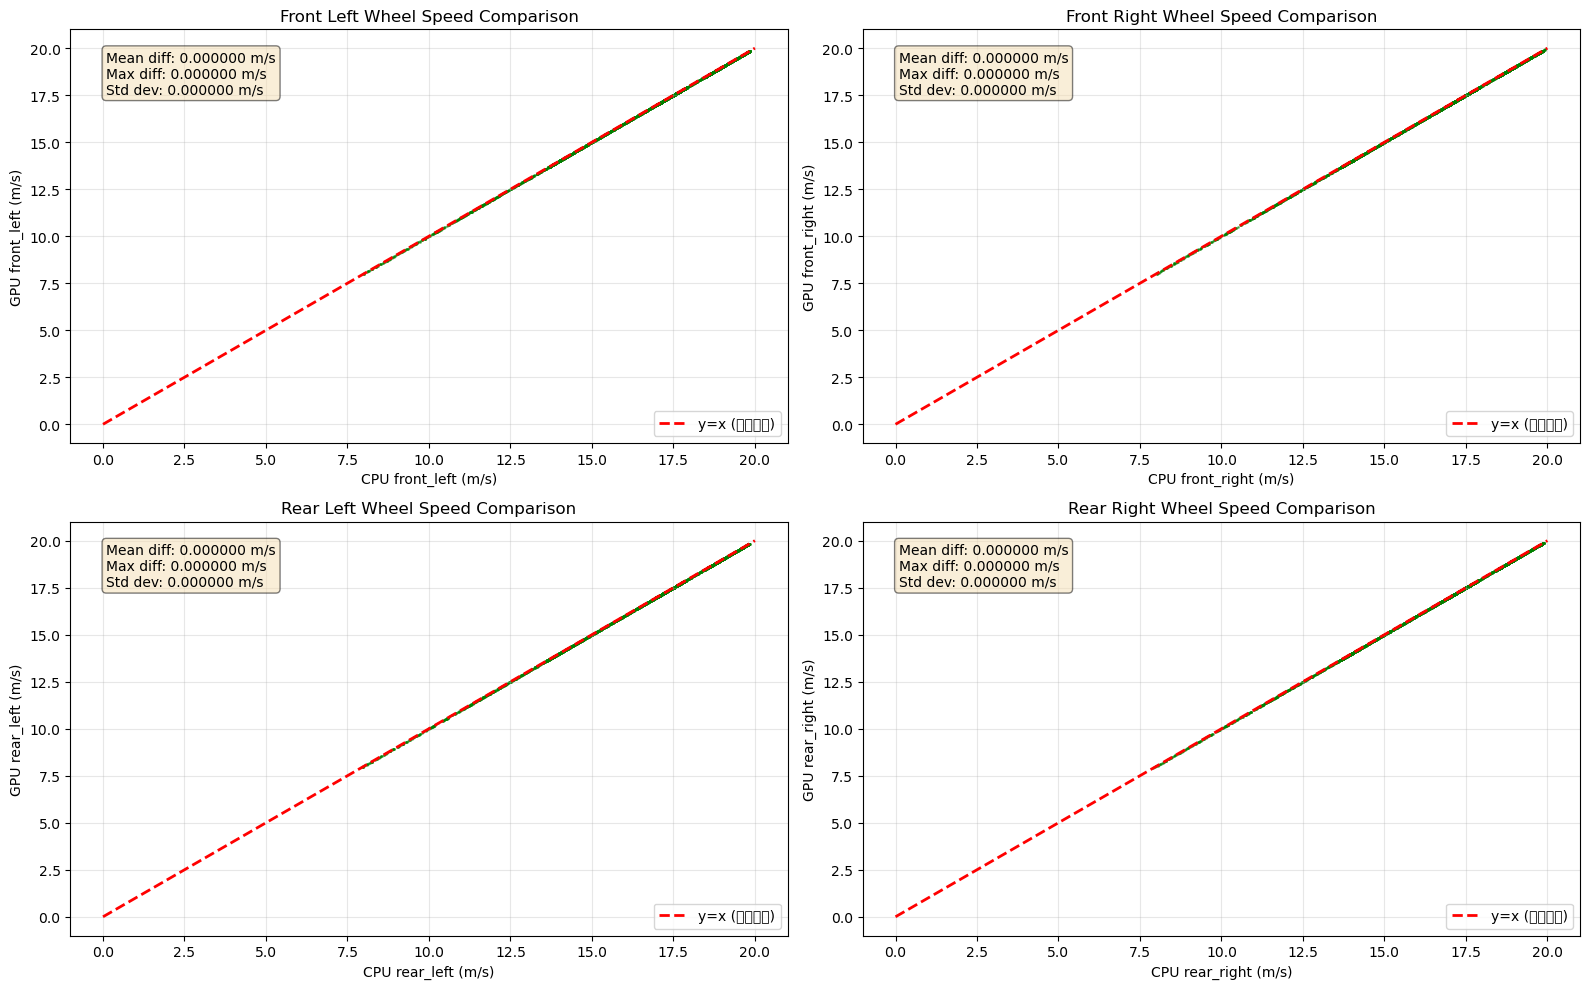


各輪の差分統計:

Front Left:
  平均差分: 0.000000000 m/s
  最大差分: 0.000000000 m/s
  標準偏差: 0.000000000 m/s
  完全一致率: 100.00%

Front Right:
  平均差分: 0.000000000 m/s
  最大差分: 0.000000000 m/s
  標準偏差: 0.000000000 m/s
  完全一致率: 100.00%

Rear Left:
  平均差分: 0.000000000 m/s
  最大差分: 0.000000000 m/s
  標準偏差: 0.000000000 m/s
  完全一致率: 100.00%

Rear Right:
  平均差分: 0.000000000 m/s
  最大差分: 0.000000000 m/s
  標準偏差: 0.000000000 m/s
  完全一致率: 100.00%


In [13]:
# 4輪速度の詳細比較
print("\n=== 4輪速度データの比較 ===")

# GPU と CPU の wheel_speeds をマージ
wheel_merged = pd.merge(gpu_wheel_speeds, cpu_wheel_speeds, 
                       on='timestamp', suffixes=('_gpu', '_cpu'))

if len(wheel_merged) > 0:
    wheel_names = ['front_left', 'front_right', 'rear_left', 'rear_right']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    for i, wheel in enumerate(wheel_names):
        # 差分計算
        wheel_diff = wheel_merged[f'{wheel}_gpu'] - wheel_merged[f'{wheel}_cpu']
        
        # プロット
        axes[i].scatter(wheel_merged[f'{wheel}_cpu'], wheel_merged[f'{wheel}_gpu'], 
                       alpha=0.5, s=1, c='green')
        axes[i].plot([0, 20], [0, 20], 'r--', linewidth=2, label='y=x (完全一致)')
        axes[i].set_xlabel(f'CPU {wheel} (m/s)')
        axes[i].set_ylabel(f'GPU {wheel} (m/s)')
        axes[i].set_title(f'{wheel.replace("_", " ").title()} Wheel Speed Comparison')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # 統計情報を表示
        text_str = f'Mean diff: {wheel_diff.mean():.6f} m/s\n'
        text_str += f'Max diff: {wheel_diff.abs().max():.6f} m/s\n'
        text_str += f'Std dev: {wheel_diff.std():.6f} m/s'
        axes[i].text(0.05, 0.95, text_str, transform=axes[i].transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', 
                    facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # 各輪の差分統計
    print("\n各輪の差分統計:")
    for wheel in wheel_names:
        wheel_diff = wheel_merged[f'{wheel}_gpu'] - wheel_merged[f'{wheel}_cpu']
        print(f"\n{wheel.replace('_', ' ').title()}:")
        print(f"  平均差分: {wheel_diff.mean():.9f} m/s")
        print(f"  最大差分: {wheel_diff.abs().max():.9f} m/s")
        print(f"  標準偏差: {wheel_diff.std():.9f} m/s")
        print(f"  完全一致率: {(wheel_diff == 0).sum() / len(wheel_diff) * 100:.2f}%")
else:
    print("警告: 4輪速度データのマージに失敗しました。")

## 4. まとめ

In [14]:
# 結果のまとめ
print("=== CANデータGPU処理の成果 ===")
print(f"\n1. パフォーマンス:")
print(f"   - 最大高速化率（GPU）: {benchmark_df['speedup'].max():.1f}x")
print(f"   - 最大GPUスループット: {benchmark_df['opt_gpu_throughput'].max():.1f} Mmessages/sec")
print(f"   - 平均CPUスループット: {benchmark_df['cpu_throughput'].mean():.2f} Mmessages/sec")

print(f"\n2. 最適化の効果:")
print(f"   - CPU事前フィルタリング: 全データの3.7%のみ処理")
print(f"   - 無駄な処理を削除: NumPy連結、型変換、copy()を除去")
print(f"   - 直接cuDF作成: 必要なデータのみGPU転送")
print(f"   - チャンクサイズによる柔軟性: 1〜並列数まで調整可能")

print(f"\n3. 出力形式:")
print(f"   - Apache Arrow準拠のParquet形式")
print(f"   - GPU: cuDFによる直接出力")
print(f"   - CPU: PyArrowによる出力")

print(f"\n4. データ品質:")
print(f"   - 両実装で同じ行数のデータを生成")
print(f"   - 4輪速度の平均から車両速度を計算")
print(f"   - タイムスタンプの一貫性を保持")

=== CANデータGPU処理の成果 ===

1. パフォーマンス:
   - 最大高速化率（GPU）: 13.7x
   - 最大GPUスループット: 147.1 Mmessages/sec
   - 平均CPUスループット: 10.94 Mmessages/sec

2. 最適化の効果:
   - CPU事前フィルタリング: 全データの3.7%のみ処理
   - 無駄な処理を削除: NumPy連結、型変換、copy()を除去
   - 直接cuDF作成: 必要なデータのみGPU転送
   - チャンクサイズによる柔軟性: 1〜並列数まで調整可能

3. 出力形式:
   - Apache Arrow準拠のParquet形式
   - GPU: cuDFによる直接出力
   - CPU: PyArrowによる出力

4. データ品質:
   - 両実装で同じ行数のデータを生成
   - 4輪速度の平均から車両速度を計算
   - タイムスタンプの一貫性を保持
